In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
file_donorA = 'donorA_interaction_10lags.csv'
file_donorB = 'donorB_interaction_10lags.csv'
file_M = 'male_interaction_10lags.csv'
file_F = 'female_interaction_10lags.csv'

# create coefficients matrix

In [63]:
def prepare_interaction_matrix(file):
    
    '''read interaction matrix created
    by fitting a BigVAR model.'''
    
    lag10_coef_df = pd.read_csv(file, index_col = [0])
    lag10_coef_df = lag10_coef_df.set_index(['otu'])

    #drop intercept
    lag10_coef_df = lag10_coef_df.drop(['V1'], axis = 1)
    #name columns
    names = [col + "_" + str(i) for i in range(1,6) for col in lag10_coef_df.index]
    lag10_coef_df.columns = names
    
    return lag10_coef_df

In [64]:
donorA_M = prepare_interaction_matrix(file_donorA)
donorB_M = prepare_interaction_matrix(file_donorB)
male_M = prepare_interaction_matrix(file_M)
female_M = prepare_interaction_matrix(file_F)

In [188]:
donorA_M.shape

(30, 150)

# check number of interactions

In [66]:
def count_interactors(df):
    """
    For each feature (otu) calculate
    number of interactors i.e. number
    of non-zero coefficients obtained 
    via the sVAR model.
    return df with otu and number of
    interactors.
    
    Parameters
    ----------
    df: interaction matrix without
        intercept of size nxn where 
        n is the number of features 
        analysed.
    """
    #convert zeros to None
    df = df.replace({0:np.NaN})
    #calculate number of interactors
    interactors = []
    names = []
    for idx in range(0,df.shape[0]):
        names.append(df.iloc[idx].name)
        interactors.append(len(df.iloc[idx].dropna()))
    #make dataframe
    interactors_df = pd.DataFrame(list(zip(names, interactors)), columns = ['otu', 'n_interactors'])
    
    return interactors_df

interactors_donorA = count_interactors(donorA_M) 
interactors_donorA['subject']='donorA'
interactors_donorB = count_interactors(donorB_M) 
interactors_donorB['subject']='donorB'
interactors_male= count_interactors(male_M) 
interactors_male['subject']='male'
interactors_female = count_interactors(female_M) 
interactors_female['subject']='female'

interactors_df=interactors_donorA.append(interactors_donorB).append(interactors_male).append(interactors_female)


sns.boxplot(data=interactors_df, y='n_interactors', x='subject', width=.5, linewidth=.6,color='white')
sns.swarmplot(data=interactors_df, y='n_interactors', x='subject', s=4, alpha=.5, palette = 'Set3')
plt.title('number of interactions among 4 subjects')
plt.savefig('plots/number_of_interactions.png')


print('total number of interactions donorA: {}'.format(interactors_donorA['n_interactors'].sum()))
print('total number of interactions donorB: {}'.format(interactors_donorB['n_interactors'].sum()))
print('total number of interactions male: {}'.format(interactors_male['n_interactors'].sum()))
print('total number of interactions female: {}'.format(interactors_female['n_interactors'].sum()))

### check the legth of interactions

In [68]:
def get_interaction_lag(df):
    
    '''create based on interactions matrix
    a df whith columns: 'coeff', 'lag', 
    'interactor','target']'''
    
    interactions_df = []
    df = df.replace({0:np.NaN})
    for idx in range(0, df.shape[0]):
        non_zero_df = df.iloc[idx].dropna()
        interaction_lag_df = pd.DataFrame(non_zero_df.tolist(), columns = ['coeff'])
        interaction_lag_df['interactor'] = non_zero_df.index #names of interactors
        interaction_lag_df[['interactor','lag']] = interaction_lag_df['interactor'].str.split('_',expand=True) 
        interaction_lag_df['target'] = non_zero_df.name #name of the target
        interactions_df.append(interaction_lag_df)
        
    interactions_df = pd.concat(interactions_df).reset_index().drop(['index'], axis = 1)
    interactions_df['n'] = interactions_df.index
    
    return interactions_df

In [69]:
def get_interaction_lag_2(df):

    interactions_df = []
    df = df.replace({0:np.NaN})
    for idx in range(0, df.shape[0]):
        non_zero_df = df.iloc[idx].dropna()
        interaction_lag_df = pd.DataFrame(non_zero_df.tolist(), columns = ['coeff'])
        interaction_lag_df['interactor'] = non_zero_df.index #names of interactors
        df3=interaction_lag_df['interactor'].str.split('_',n=1,expand=True)
        df3.columns = ['VAR{}'.format(x+1) for x in df3.columns]
        interaction_lag_df=interaction_lag_df.join(df3)
        interaction_lag_df['target'] = non_zero_df.name
        interactions_df.append(interaction_lag_df)
    interactions_df = pd.concat(interactions_df).reset_index().drop(['index'], axis = 1)
    interactions_df=interactions_df.drop(['VAR1'], axis=1)
    interactions_df['n'] = interactions_df.index
    interactions_df = interactions_df.rename({'VAR2':'lag'}, axis=1)
    
    return interactions_df

In [96]:
interaction_lag_df_donorA = get_interaction_lag(donorA_M)
interaction_lag_df_donorB = get_interaction_lag_2(donorB_M)
interaction_lag_df_male = get_interaction_lag(male_M)
interaction_lag_df_female = get_interaction_lag_2(female_M)

In [241]:
q = (interaction_lag_df['abs_coeff']).quantile(.3)

In [235]:
interaction_lag_df['abs_coeff'] = np.abs(interaction_lag_df['coeff'])

In [97]:
#join
interaction_lag_df_donorA['subject']='donorA'
interaction_lag_df_donorB['subject']='donorB'
interaction_lag_df_male['subject']='male'
interaction_lag_df_female['subject']='female'

interaction_lag_df = interaction_lag_df_donorA.append(interaction_lag_df_donorB).append(interaction_lag_df_male).append(interaction_lag_df_female)

### lag distribution among subjects

In [85]:
lag_distribution_df = pd.DataFrame(interaction_lag_df.groupby(['subject', 'lag']).size()).reset_index()#.unstack(fill_value=0)
lag_distribution_df = lag_distribution_df.rename({0:'n'}, axis=1)

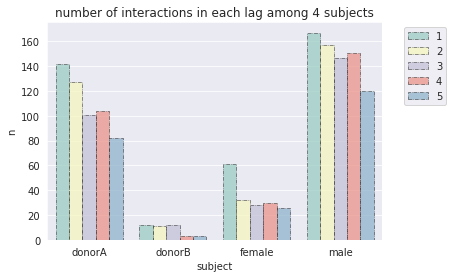

In [150]:
kwargs={'alpha':.7}
ax=sns.barplot(data = lag_distribution_df,
            x = 'subject',
            y = 'n',
            hue = 'lag',
            palette="Set3", 
            linewidth=.6, edgecolor = 'black', linestyle="-.", **kwargs)
ax.legend(bbox_to_anchor=(1.05, 1.0))
plt.title('number of interactions in each lag among 4 subjects')
plt.savefig('plots/number_of_interactions_in_each_lag_among_4_subjects.png')

### coefficient strength among lags

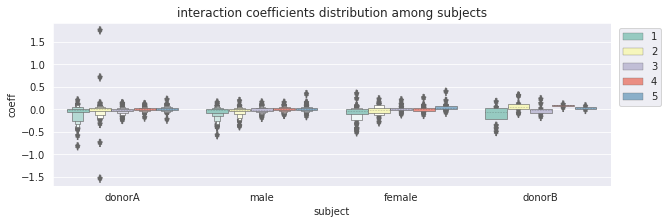

In [153]:
coeff_strength_df = interaction_lag_df.copy()
coeff_strength_df['lag'] = coeff_strength_df['lag'].astype(int)
coeff_strength_df['coeff'] = np.abs(coeff_strength_df['coeff'])
#plot
plt.figure(figsize = [10, 3])
ax = sns.boxenplot(data=interaction_lag_df.sort_values(by ='lag'),
              y='coeff',
              x='subject',
              hue='lag',
              palette = 'Set3',
              linewidth=.6,
              linestyle=':'
             )

ax.legend(bbox_to_anchor=(1.1, 1.0))
plt.title('interaction coefficients distribution among subjects')
plt.savefig('plots/interaction_coefficients_distribution_among_subjects.png')

### find and remove interactions with opposite sign 

In [101]:
def find_interactions_of_opposite_sign(df):
    
    '''Find pairs of interactions that have
    coefficients with different sign. These
    interactions are inconsistent
    
    Parameters
    ----------
    df: dataframe with pairwise interations
    with columns['interactor','target', 'lag',
    'coefficient']
    
    Returns
    ----------
    remove_columns_df: df with otu pairs to 
    be removed
    '''
    remove_col_df=[]
    for i in df['target'].unique():
        target_df=df[df['target'] ==i]
        for j in target_df['interactor']:
            x = target_df[target_df['interactor'] == j]

            if all(item >= 0 for item in x['coeff']) or all(item < 0 for item in x['coeff']) == True:
                pass
            else:
                remove_col_df.append(x)

    remove_col_df = pd.concat(remove_col_df).reset_index().drop(['index'], axis = 1)
    consistent_coeff_sign_df = df[~df['n'].isin(remove_col_df['n'])].drop(['n'], axis = 1)
    
    return remove_col_df

In [216]:
consistent_coeff_sign_donorA=find_interactions_of_opposite_sign(interaction_lag_df_donorA)
consistent_coeff_sign_donorB=interaction_lag_df_donorB
consistent_coeff_sign_male=find_interactions_of_opposite_sign(interaction_lag_df_male)
consistent_coeff_sign_female=interaction_lag_df_female

In [217]:
consistent_df = consistent_coeff_sign_donorA.append(consistent_coeff_sign_donorB).append(consistent_coeff_sign_male).append(consistent_coeff_sign_female)

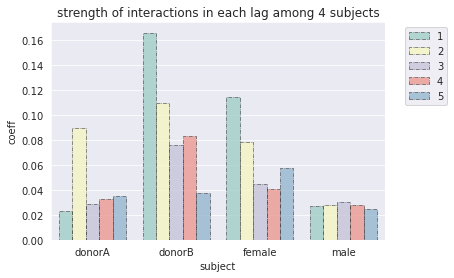

In [218]:
coeff_strength_df = pd.DataFrame(coeff_strength_df.groupby(['subject', 'lag', 'coeff']).size()).reset_index()#.unstack(fill_value=0)
coeff_strength_df = coeff_strength_df.rename({0:'n'}, axis=1)
coeff_strength_df['coeff'] = np.abs(coeff_strength_df['coeff'])

kwargs={'alpha':.7}
ax = sns.barplot(data = coeff_strength_df,
            x = 'subject',
            y = 'coeff',
            hue = 'lag',
            palette="Set3", 
            linewidth=.6,
            edgecolor = 'black',
            linestyle="-.",
            ci=None,
            **kwargs)
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.title('strength of interactions in each lag among 4 subjects')
plt.savefig('plots/strength_of_interactions_in_each_lag_among_4_subjects.png')

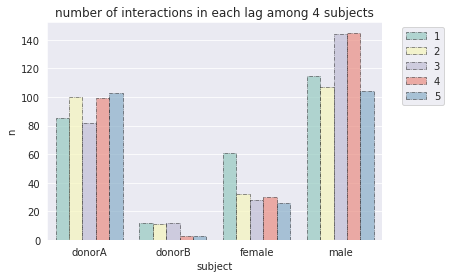

In [219]:
lag_distribution_df = pd.DataFrame(consistent_df.groupby(['subject', 'lag']).size()).reset_index()#.unstack(fill_value=0)
lag_distribution_df = lag_distribution_df.rename({0:'n'}, axis=1)
lag_distribution_df.head(2)

kwargs={'alpha':.7}
ax = sns.barplot(data = lag_distribution_df,
            x = 'subject',
            y = 'n',
            hue = 'lag',
            palette="Set3", 
            linewidth=.6,
            edgecolor = 'black',
            linestyle="-.",
            ci=None,
            **kwargs)
ax.legend(bbox_to_anchor=(1.2, 1.0))
plt.title('number of interactions in each lag among 4 subjects')
plt.savefig('plots/number_of_interactions_in_each_lag_among_4_subjects.png')

In [201]:
def count_interactors(df):
    """
    For each feature (otu) calculate
    number of interactors i.e. number
    of non-zero coefficients obtained 
    via the sVAR model.
    return df with otu and number of
    interactors.
    
    Parameters
    ----------
    df: interaction matrix without
        intercept of size nxn where 
        n is the number of features 
        analysed.
    """
    #convert zeros to None
    df = df.replace({0:np.NaN})
    #calculate number of interactors
    interactors = []
    names = []
    for idx in range(0,df.shape[0]):
        names.append(df.iloc[idx].name)
        interactors.append(len(df.iloc[idx].dropna()))
    #make dataframe
    interactors_df = pd.DataFrame(list(zip(names, interactors)), columns = ['otu', 'n_interactors'])
    
    return interactors_df

interactors_donorA = count_interactors(donorA_M) 

### analyse long and short term interactions

In [173]:
def analyse_interaction_by_day(df, subject):
    
    INTERACTION = []
    COL = []

    for col in df['target'].unique():

        target_df = df[df['target'] == col]
        target_df['lag'] = target_df['lag'].astype(int)

        lag1 = target_df[target_df['lag']==1].shape[0]
        lag2 = target_df[target_df['lag']==2].shape[0]
        lag3 = target_df[target_df['lag']==3].shape[0]
        lag4 = target_df[target_df['lag']==4].shape[0]
        lag5 = target_df[target_df['lag']==5].shape[0]
        
        lag1_df = pd.DataFrame()
        lag1_df['target'] = [col]            
        lag1_df['n'] = [lag1]
        lag1_df['lag'] = ['lag1']

        lag2_df = pd.DataFrame()
        lag2_df['target'] = [col] 
        lag2_df['n'] = [lag2]
        lag2_df['lag'] = ['lag2']
        
        lag3_df = pd.DataFrame()
        lag3_df['target'] = [col] 
        lag3_df['n'] = [lag3]
        lag3_df['lag'] = ['lag3']
        
        lag4_df = pd.DataFrame()
        lag4_df['target'] = [col] 
        lag4_df['n'] = [lag4]
        lag4_df['lag'] = ['lag4']
        
        lag5_df = pd.DataFrame()
        lag5_df['target'] = [col] 
        lag5_df['n'] = [lag5]
        lag5_df['lag'] = ['lag5']

        int_df = lag1_df.append(lag2_df).append(lag3_df).append(lag4_df).append(lag5_df)

        INTERACTION.append(int_df)

    INTERACTION = pd.concat(INTERACTION)
    INTERACTION['subject'] = subject
    
    return INTERACTION

In [174]:
interactions_day_donorA = analyse_interaction_by_day(consistent_coeff_sign_donorA, 'donorA')
interactions_day_donorB = analyse_interaction_by_day(consistent_coeff_sign_donorB, 'donorB')
interactions_day_male = analyse_interaction_by_day(consistent_coeff_sign_male, 'male')
interactions_day_female = analyse_interaction_by_day(consistent_coeff_sign_female, 'female')

In [175]:
INTERACTIONS_DAY_DF = interactions_day_donorA.append(interactions_day_donorB).append(interactions_day_male).append(interactions_day_female)

<AxesSubplot:xlabel='subject', ylabel='n'>

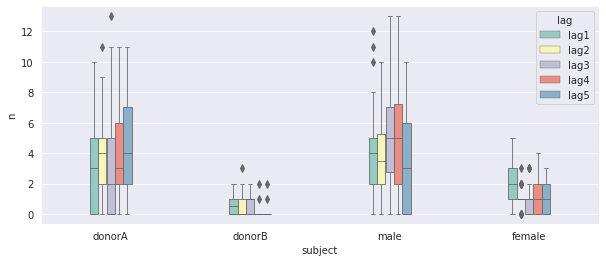

In [121]:
plt.figure(figsize = [10, 4])
sns.boxplot(data=INTERACTIONS_DAY_DF, x = 'subject', y='n', hue = 'lag', palette = 'Set3', linewidth = .8, width=.3)

In [35]:
def define_interaction_type(df):
    
    ''' for each otu find out if it's interactions
    are mostly short (interactions on 1-6 day) or long-term 
    (interactions on 6-10lags) '''
    
    INTERACTION_DF = []
    for col in df['target'].unique():

        target_df = df[df['target'] == col]

        short_int = [int(i) for i in range(1,3)]
        long_int = [int(i) for i in range(3,6)]
        target_df['interaction'] = np.where(target_df['lag'].astype(int).isin(short_int), 'short-term', 'long-term')

        interactions_df = pd.DataFrame(columns =['target'])
        
        try: #for otu with long and short interactions

            s = target_df['interaction'].value_counts()[0]#short
            l = target_df['interaction'].value_counts()[1]#long

            if s>l:
                interactions_df['target'] = target_df['target'].unique()
                interactions_df['interaction'] = 'short-term'
            elif s<l:
                interactions_df['target'] = target_df['target'].unique()
                interactions_df['interaction'] = 'long-term'
            elif s == l:
                interactions_df['target'] = target_df['target'].unique()
                interactions_df['interaction'] = 'equal'

        except: #if otu has only one type of interactions
            s = target_df['interaction'].value_counts()[0]
            if s in short_int:
                interactions_df['target'] = target_df['target'].unique()
                interactions_df['interaction'] = 'short-term'
            elif s in long_int:
                interactions_df['target'] = target_df['target'].unique()
                interactions_df['interaction'] = 'long-term'

        INTERACTION_DF.append(interactions_df)

    INTERACTION_DF = pd.concat(INTERACTION_DF)
    
    return INTERACTION_DF

In [36]:
long_short_term_int_donorA = define_interaction_type(consistent_coeff_sign_donorA).reset_index()
long_short_term_int_donorA['subject']='donorA'
long_short_term_int_donorB = define_interaction_type(consistent_coeff_sign_donorB).reset_index()
long_short_term_int_donorB['subject']='donorB'
long_short_term_int_male = define_interaction_type(consistent_coeff_sign_male).reset_index()
long_short_term_int_male['subject']='male'
long_short_term_int_female = define_interaction_type(consistent_coeff_sign_female).reset_index()
long_short_term_int_female['subject']='female'

In [37]:
long_short_term_int_df = long_short_term_int_donorA.append(long_short_term_int_donorB).append(long_short_term_int_male).append(long_short_term_int_female)

In [38]:
d=long_short_term_int_df.groupby(['subject', 'interaction']).size().unstack(fill_value=0).reset_index()

In [39]:
d=long_short_term_int_df.groupby(['subject', 'interaction']).size().unstack(fill_value=0).reset_index()
#equal
d1=d.drop(['long-term', 'short-term'], axis=1).rename({'equal':'interaction-time'}, axis=1)
d1['time']='equal'
#long
d2=d.drop(['short-term', 'equal'], axis=1).rename({'long-term':'interaction-time'}, axis=1)
d2['time']='long-term'
#short
d3=d.drop(['long-term', 'equal'], axis=1).rename({'short-term':'interaction-time'}, axis=1)
d3['time']='short-term'

d4=d1.append(d2).append(d3)

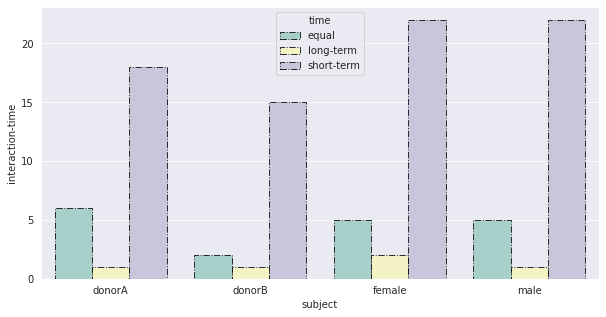

In [40]:
plt.figure(figsize = [10, 5])
kwargs={'alpha':.8, 'linestyle':'-.', 'linewidth':1}
sns.barplot(data = d4, y = 'interaction-time', x = 'subject', hue='time',palette='Set3', edgecolor='black', **kwargs)
plt.savefig('plots/duration_of_interactions.png')

### find coefficients direction

In [179]:
consistent_coeff_sign_donorA['coeff_sign'] = np.where(consistent_coeff_sign_donorA['coeff']<0, 'negative', 'positive')
consistent_coeff_sign_donorB['coeff_sign'] = np.where(consistent_coeff_sign_donorB['coeff']<0, 'negative', 'positive')
consistent_coeff_sign_male['coeff_sign'] = np.where(consistent_coeff_sign_male['coeff']<0, 'negative', 'positive')
consistent_coeff_sign_female['coeff_sign'] = np.where(consistent_coeff_sign_female['coeff']<0, 'negative', 'positive')

In [180]:
coefficient_direction_df=consistent_coeff_sign_donorA.append(consistent_coeff_sign_donorB).append(consistent_coeff_sign_male).append(consistent_coeff_sign_female)

In [181]:
d=coefficient_direction_df.groupby(['subject', 'coeff_sign']).size().unstack(fill_value=0).reset_index()
#negative
d1=d.drop(['positive'], axis=1).rename({'negative':'count'}, axis=1)
d1['direction']='positive'
#positive
d2=d.drop(['negative'], axis=1).rename({'positive':'count'}, axis=1)
d2['direction']='negative'

d3=d1.append(d2)

Text(0.5, 1.0, 'number of positive/negative interactions in df')

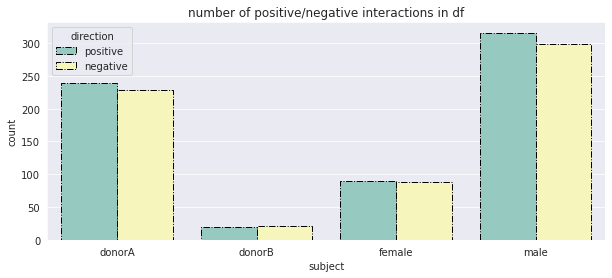

In [182]:
plt.figure(figsize = [10, 4])
kwargs={'alpha':1, 'linestyle':'-.', 'linewidth':1}
sns.barplot(data = d3, x= 'subject', y = 'count', hue='direction', palette='Set3', edgecolor='black', **kwargs)
plt.title('number of positive/negative interactions in df')
#plt.savefig('plots/interactions_direction.png')

### find strongest interactions

In [400]:
def find_stongest_interactions(df):
    prc95, prc5=df['coeff'].quantile(.95), df['coeff'].quantile(.5)
    
    strongest_positive_int=df[df['coeff'].astype(float)>prc95]
    strongest_positive_int['pair'] = strongest_positive_int['target'] + '_' + strongest_positive_int['interactor']
    strongest_positive_int=strongest_positive_int.drop_duplicates()
    strongest_positive_int=strongest_positive_int.set_index(['pair'])
    
    strongest_negative_int=df[df['coeff'].astype(float)<prc5]
    strongest_negative_int['pair'] = strongest_negative_int['target'] + '_' + strongest_negative_int['interactor']
    strongest_negative_int=strongest_negative_int.drop_duplicates()
    strongest_negative_int=strongest_negative_int.set_index(['pair'])

    return strongest_positive_int, strongest_negative_int

In [401]:
strongest_positive_int_donorA, strongest_negative_int_donorA = find_stongest_interactions(consistent_coeff_sign_donorA)
strongest_positive_int_donorB, strongest_negative_int_donorB = find_stongest_interactions(interaction_lag_df_donorB)
strongest_positive_int_male, strongest_negative_int_male = find_stongest_interactions(consistent_coeff_sign_male)
strongest_positive_int_female, strongest_negative_int_female= find_stongest_interactions(interaction_lag_df_female)

In [402]:
idx=strongest_negative_int_donorA.index.append(strongest_negative_int_donorB.index).append(strongest_negative_int_male.index).append(strongest_negative_int_female.index)
import collections
print([item for item, count in collections.Counter(idx).items() if count > 4])

[]


## autoregression coeff

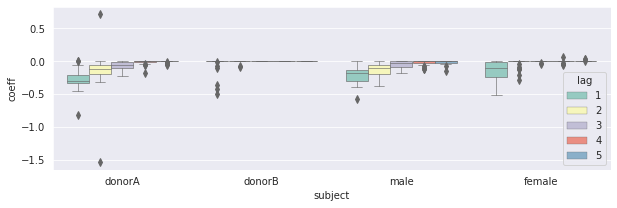

In [410]:
def find_autocorr(df, subject):
    
    AUTOREG_DF = []
    for i in range(1, 6):

        lag = '_' + str(i)
        autoreg_df = pd.DataFrame(np.diag(df.filter(like = lag)), columns = ['coeff'])
        autoreg_df['target'] = df.index
        autoreg_df['subject'] = subject
        autoreg_df['lag'] = i

        AUTOREG_DF.append(autoreg_df)

    AUTOREG_DF = pd.concat(AUTOREG_DF)
    
    return AUTOREG_DF

autocorr_donorA = find_autocorr(donorA_M, 'donorA')
autocorr_donorB = find_autocorr(donorB_M, 'donorB')
autocorr_male = find_autocorr(male_M, 'male')
autocorr_female = find_autocorr(female_M, 'female')


autocorr_df = autocorr_donorA.append(autocorr_donorB).append(autocorr_male).append(autocorr_female)

plt.figure(figsize = [10, 3])
sns.boxplot(data=autocorr_df, x = 'subject', y = 'coeff', hue = 'lag', linewidth = .6, palette = 'Set3')
plt.savefig('plots/autoregression.png')

In [411]:
def calculate_autoregression_index(auto_df, inter_df, subject):
    
    TARGET = []
    LAG = []
    INDEX = []
    for target in auto_df['target'].unique():

        for lag in range(1, 6):

            auto_df['lag']=auto_df['lag'].astype(int)
            df1 = auto_df[auto_df['lag']==lag]
            df1=df1[df1['target']==target]
            df1['coeff'] = np.abs(df1['coeff'])
            autoreg = df1['coeff'].tolist()

            inter_df['lag']=inter_df['lag'].astype(int)
            df2 = inter_df[inter_df['lag']==lag]
            df2=df2[df2['target']==target]
            df2['coeff'] = np.abs(df2['coeff'])

            divider = df2['coeff'].sum() + autoreg
            autoregression_index = autoreg/divider
            try:

                autoregression_index = autoregression_index[0].astype(np.float)
                TARGET.append(target)
                LAG.append(lag)
                INDEX.append(autoregression_index)

            except:
                TARGET.append(target)
                LAG.append(lag)
                INDEX.append(0)
                
    autoregession_df = pd.DataFrame(list(zip(TARGET, LAG, INDEX)),
                                    columns = ['otu', 'lag', 'autoregression_index']).drop_duplicates(subset=['otu', 'lag'])
    autoregession_df['subject'] = subject
    
    return autoregession_df

In [414]:
autoreg_donorA = calculate_autoregression_index(autocorr_donorA, interaction_lag_df_donorA, 'donorA')
autoreg_donorB = calculate_autoregression_index(autocorr_donorB, interaction_lag_df_donorB, 'donorB')
autoreg_male = calculate_autoregression_index(autocorr_male, interaction_lag_df_male, 'male')
autoreg_female = calculate_autoregression_index(autocorr_female, interaction_lag_df_female, 'female')


TypeError: unsupported operand type(s) for +: 'float' and 'list'

In [299]:
autoreg_donorA = calculate_autoregression_index(autocorr_donorA, interaction_lag_df_donorA, 'donorA')
#autoreg_donorB = calculate_autoregression_index(autoregressive_interactions_donorB, interaction_lag_df_donorB)
autoreg_male = calculate_autoregression_index(autoregressive_interactions_male, interaction_lag_df_male, 'male')
#calculate_autoregression_index(autoregressive_interactions_donorB, interaction_lag_df_donorB)

In [302]:
a = autoreg_donorA.append(autoreg_male)

<AxesSubplot:xlabel='lag', ylabel='autoregression_index'>

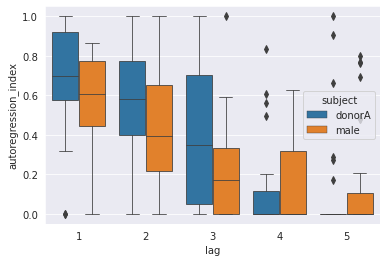

In [305]:
sns.boxplot(data=a, y='autoregression_index', x='lag', hue = 'subject', linewidth=.8)
#sns.swarmplot(data=a, y='autoregression_index', x='lag', s=5, alpha = .5, hue = 'subject')

Text(0.5, 1.0, 'autoregresive coefficients distribution among lags')

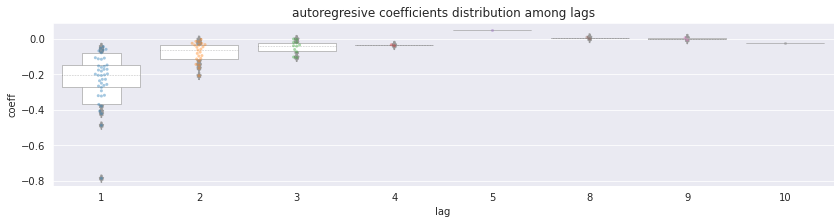

In [110]:
autoregressive_interactions['lag']=autoregressive_interactions['lag'].astype(int)
plt.figure(figsize = [14, 3])
sns.boxenplot(data=autoregressive_interactions.sort_values(by ='lag'), y='coeff', x='lag', color='white',linewidth=.6, linestyle=':')
sns.swarmplot(data=autoregressive_interactions.sort_values(by ='lag'), y='coeff', x='lag', s=3, alpha=.4)
plt.title('autoregresive coefficients distribution among lags')